In [1]:
import os
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torchvision.utils import save_image
from util import stopwatch, get_stopwatch
import numpy as np
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

save_img_row_size = 8
label_list = "plane autos birds cats_ deer_ dogs_ frogs horse ships truck".split(" ")
def save_labels(labels, path):
    with open(path, 'w') as f:
        for i, label in enumerate(labels.detach().numpy()):
            l = np.where(label==1)[0][0]
            print(label_list[l], file=f, end=('\n' if (i+1) % save_img_row_size == 0 else ' '))
torch.manual_seed(7)

## TODO Try auxiliary task of determining class as way of improving generation
Also try CIFAR100 with word embeddings

In [44]:
num_epochs = 1000
batch_size = 100
num_labels = 10

sample_dir = 'samples_dc_cond_cifar_onehost'
if not os.path.exists(sample_dir): os.makedirs(sample_dir)
    
fake_img_dir = os.path.join(sample_dir, 'fake_images')
if not os.path.exists(fake_img_dir): os.makedirs(fake_img_dir)

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))])
def denorm(x): return ((x+1)/2).clamp(0,1)

def one_hot(x):
    r = torch.zeros(num_labels)
    try: r[x] = 1
    except: r[x.item()] = 1
    return r
dataset = torchvision.datasets.CIFAR10(root='~/cifar10-data/', train=True, download=True,
                                   transform=transform) #, target_transform=one_hot) <- not using since using embedding

data_loader = torch.utils.data.DataLoader(dataset=dataset, batch_size = batch_size, shuffle=True)

Files already downloaded and verified


In [3]:
from matplotlib import pyplot as plt
show_i = 4
print("{} images of {}".format(len(dataset), dataset[1][0].shape))
print(dataset[show_i][1])
print(dataset[show_i][0].shape)
plt.imshow(denorm(dataset[show_i][0].permute(1,2,0)))

50000 images of torch.Size([3, 32, 32])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
torch.Size([3, 32, 32])


In [53]:
latent_size = 64
image_size = 32 * 32
num_colors = 3
num_kernels = 32
embedding_size = 64
E = nn.Embedding(num_labels, embedding_size)

In [60]:
class Discriminator(nn.Module):
    def __init__(self, E):
        super(Discriminator, self).__init__()
        self.D1 = nn.Sequential(
                    # add label to each pixel in input. (10+3) * 32 * 32
                    nn.Conv2d(embedding_size+num_colors, num_kernels, 2, 2, 0),
                    # 32x16x16
                    nn.LeakyReLU(0.2),
                    nn.Conv2d(num_kernels, num_kernels*2, 3, 2, 1),
                    # 64x8x8
                    nn.BatchNorm2d(num_kernels * 2),
                    nn.LeakyReLU(0.2),
                    nn.Conv2d(num_kernels*2, num_kernels*4, 2, 1),
                    # 128x7x7
                    nn.BatchNorm2d(num_kernels * 4),
                    nn.LeakyReLU(0.2),
                    nn.Conv2d(num_kernels*4, num_kernels*8, 2, 2),
                    # 256x3x3
                    nn.BatchNorm2d(num_kernels * 8),
                    nn.LeakyReLU(0.2))
        self.D2 = nn.Sequential(nn.Conv2d(num_kernels*8, 1, 3), nn.Sigmoid())
        self.E = E
        
    def get_embedding(self, images, labels):
        embeddings = self.E(labels)
        embeddings_dups = embeddings.unsqueeze(dim=-1).unsqueeze(dim=-1).expand(embeddings.shape+images.shape[2:])
        d_inputs = torch.cat((images, embeddings_dups), 1)
        return self.D1(d_inputs)
    
    def forward(self, images, labels):
        return self.D2(self.get_embedding(images, labels))
D = Discriminator(E)
D = D.to(device)
D_losses = []

In [61]:
class Generator(nn.Module):
    def __init__(self, E):
        super(Generator, self).__init__()
        self.G = nn.Sequential(
                    nn.ConvTranspose2d(latent_size+embedding_size, num_kernels*8, 3, 1, 0),
                    # 256x3x3
                    nn.BatchNorm2d(num_kernels*8),
                    nn.ReLU(),
                    nn.ConvTranspose2d(num_kernels*8, num_kernels*4, 2, 2, 1),
                    # 128x5x5
                    nn.BatchNorm2d(num_kernels*4),
                    nn.ReLU(),
                    nn.ConvTranspose2d(num_kernels*4, num_kernels*2, 2, 2, 0, 1),
                    # 64x9x9
                    nn.BatchNorm2d(num_kernels*2),
                    nn.ReLU(),
                    nn.ConvTranspose2d(num_kernels*2, num_kernels*3//2, 3, 2, 1),
                    nn.BatchNorm2d(num_kernels*3//2),
                    nn.ReLU(),
                    nn.ConvTranspose2d(num_kernels*3//2, num_kernels, 2, 1, 1),
                    # 32x16x16
                    nn.BatchNorm2d(num_kernels),
                    nn.ReLU(),
                    nn.ConvTranspose2d(num_kernels, num_colors, 2, 2, 0),
                    nn.Tanh())
        self.E = E
    
    def forward(self, labels, z=None):
        if z is None: z = torch.randn(labels.shape[0], latent_size)
        z = z.to(device)
        embeddings = self.E(labels)
        g_inputs = torch.cat((z, embeddings), 1) # batch_size * latent_dim
        g_inputs = g_inputs.unsqueeze(-1).unsqueeze(-1) # -> batch_size * latent_dim * 1 * 1 for DC generator
        return self.G(g_inputs)
G = Generator(E)
G = G.to(device)
G_losses = []

In [62]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

def reset_grad(): d_optimizer.zero_grad(); g_optimizer.zero_grad()

In [63]:
def save_generated_images(G, epoch, labels = None, z = None, nrow = 10):
    if labels is None:
        labels = torch.LongTensor([i//10 for i in range(100)]).to(device)
    fake_images = G(labels, z)
    save_image(denorm(fake_images), os.path.join(fake_img_dir, 'fake_images-{}.png'.format(epoch+1)), nrow=nrow)

In [ ]:
import pickle as pkl

total_step = len(data_loader)
demo_z = torch.randn(100, latent_size)
for epoch in range(num_epochs):
    stopwatch()
    pkl.dump({'D_losses': D_losses, 'G_losses': G_losses}, open(os.path.join(sample_dir, 'losses.pkl'), 'wb'))
    D_loss_this_epoch = []
    G_loss_this_epoch = []
    D_losses.append(D_loss_this_epoch)
    G_losses.append(G_loss_this_epoch)
    G.train()
    D.train()
    
    for i, (images, labels_cpu) in enumerate(data_loader):
        real_labels = torch.ones (batch_size, 1, 1, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1, 1, 1).to(device)
        labels = labels_cpu.to(device)
        
        ## discriminator
        # input real images to discriminator
        images = images.to(device)
        outputs = D(images, labels)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs
        
        # generate fake images and feed to discriminator
        fake_images = G(labels)
        outputs = D(fake_images, labels)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs
        
        # compute total loss and backprop
        d_loss = d_loss_real + d_loss_fake
        reset_grad()
        d_loss.backward()
        d_optimizer.step()
        
        ## generator
        # generate fake images and feed to discriminator
        fake_images = G(labels)
        outputs = D(fake_images, labels)
        
        # compute loss for generator and backprop
        g_loss = criterion(outputs, real_labels)
        reset_grad()
        g_loss.backward()
        g_optimizer.step()
        
        if (i+1) % 25 == 0:
            # only gets a subsample of the losses but that's okay
            D_loss_this_epoch.append(d_loss.item())
            G_loss_this_epoch.append(g_loss.item())
            t = get_stopwatch()
            print('Epoch [{}/{}], [{}/{}] ({:.1f}s/{:.1f}s) dl({:.4f}) gl({:.4f}), D(x)={:.2f}, D(G(z))={:.2f}'
                  .format(epoch, num_epochs, i+1, total_step,
                          t, t*total_step/i,
                          d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()), end="\r")
    print("")
    if epoch == 0: save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'))
    if epoch < 10 or \
       (epoch < 100 and (epoch+1) % 5 == 0) or \
       (epoch < 200 and (epoch+1) % 10 == 0) or \
       (epoch+1) % 20 == 0: save_generated_images(G, epoch, z = demo_z)
    
    if (epoch+1) % 20 == 0:
        torch.save(G.state_dict(), os.path.join(sample_dir, 'G_cond_{}.ckpt'.format(epoch)))
        torch.save(D.state_dict(), os.path.join(sample_dir, 'D_cond_{}.ckpt'.format(epoch)))


Epoch [0/1000], [500/500] (42.9s/43.0s) dl(0.1998) gl(3.5707), D(x)=0.96, D(G(z))=0.15
Epoch [1/1000], [500/500] (42.6s/42.7s) dl(0.6271) gl(2.2363), D(x)=0.78, D(G(z))=0.19
Epoch [2/1000], [500/500] (42.6s/42.7s) dl(0.4892) gl(1.4402), D(x)=0.91, D(G(z))=0.30
Epoch [3/1000], [500/500] (42.6s/42.6s) dl(0.5392) gl(2.3291), D(x)=0.79, D(G(z))=0.12
Epoch [4/1000], [500/500] (42.7s/42.8s) dl(0.6698) gl(1.3198), D(x)=0.84, D(G(z))=0.32
Epoch [5/1000], [500/500] (42.7s/42.8s) dl(1.4626) gl(2.3168), D(x)=0.39, D(G(z))=0.10
Epoch [6/1000], [500/500] (42.6s/42.7s) dl(0.7116) gl(1.7032), D(x)=0.66, D(G(z))=0.15
Epoch [7/1000], [500/500] (42.5s/42.6s) dl(0.5837) gl(1.7963), D(x)=0.82, D(G(z))=0.26
Epoch [8/1000], [500/500] (42.8s/42.9s) dl(0.3688) gl(3.7603), D(x)=0.80, D(G(z))=0.07
Epoch [9/1000], [500/500] (42.6s/42.7s) dl(0.5195) gl(2.9717), D(x)=0.72, D(G(z))=0.10
Epoch [10/1000], [500/500] (42.6s/42.7s) dl(0.6271) gl(3.2726), D(x)=0.64, D(G(z))=0.08
Epoch [11/1000], [500/500] (42.5s/42.6s) d

In [40]:
torch.save(G.state_dict(), os.path.join(sample_dir, 'G_cond_{}.ckpt'.format(epoch)))
torch.save(D.state_dict(), os.path.join(sample_dir, 'D_cond_{}.ckpt'.format(epoch)))

In [121]:
# [(image, [nearest_neighbours]), ...]
def generate_images(G, category, num):
    G.eval()
    z = torch.randn(num, latent_size).to(device)
    # get num x num_labels matrix of one-hot vectors indicating the category
    labels = torch.zeros(num_labels)
    labels[category] = 1
    labels = labels.unsqueeze(0).expand(num, num_labels).to(device)
    g_inputs = torch.cat((z, labels), 1) # num * latent_dim
    g_inputs = g_inputs.unsqueeze(-1).unsqueeze(-1) # -> num * latent_dim * 1 * 1 for DC generator
    fake_images = G(g_inputs)
    return denorm(fake_images).detach()

ships


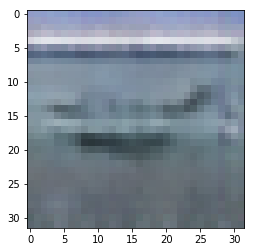

In [168]:
category = 8
print(label_list[category])
imgs = generate_images(G, category, 10)
plt.imshow(imgs[1].cpu().permute(1,2,0).numpy())

In [108]:
print("test")

test
